#Pobranie i instalacja odpowiednich bibliotek

In [ ]:
!wget -O - http://download.sgjp.pl/apt/sgjp.gpg.key|sudo apt-key add -
!sudo apt-add-repository http://download.sgjp.pl/apt/ubuntu
!sudo apt update
!sudo apt install morfeusz2
!sudo apt install python3-morfeusz2

# instalacja spaCy
!python3 -m pip install spacy

# 1. instalacja modelu IPI PAN dla języka polskiego
!wget "http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz"
!mv 'SpacyPL?action=AttachFile&do=get&target=pl_spacy_model_morfeusz-0.1.3.tar.gz' pl_spacy_model_morfeusz-0.1.3.tar.gz
!python3 -m pip install pl_spacy_model_morfeusz-0.1.3.tar.gz

# linkowanie modelu do spaCy
!python3 -m spacy link pl_spacy_model_morfeusz pl_spacy_model_morfeusz -f

# 2. instalacja oficjalnego modelu spaCy
!python3 -m spacy download pl_core_news_lg

# dodatkowe zależności:
!python3 -m pip install tqdm
!python3 -m pip install networkx

#Import niezbędnych bibliotek

In [68]:
import spacy
import requests
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools as fs
import re
import morfeusz2
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nlp = spacy.load("pl_spacy_model_morfeusz") # IPI PAN

**Deklaracja funkcji tokenizujących**

In [15]:
def tokenizer(document):
  tokens = nlp(document)
  tokens = [ token.lemma_  for token in tokens if (
      bool(re.search(r'^[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]*[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]$',token.lemma_)) and \
      token.is_stop == False and \
      token.is_punct == False and \
      token.tag_ == 'subst')] 
  return tokens

def tokenizer_lemma_token(document):
  tokens = nlp(document)
  tokens = [token for token in tokens if (
      bool(re.search(r'^[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]*[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]$',token.lemma_)) and \
      token.is_stop == False and \
      token.is_punct == False and\
      bool(token._.feats) == True and \
      token._.feats != '' )] 
  return tokens

**Deklaracja funkcji tworzącej tabele analityczną dla kolekcji tokenów**

In [16]:
def create_table(tokens):
  table = []
  for tok in tokens:
    tok_dic = {"form": tok.orth_, "lemma": tok.lemma_, "tag": tok.tag_, "tok_feats": tok._.feats, "pos": tok.pos_}
    table.append(tok_dic)
  return table

# **1. Utworzyć korpus dokumentów na podstawie 5-10 książek pobranych ze strony Wolne Lektury: https://wolnelektury.pl/**

In [49]:
url = [
"https://wolnelektury.pl/media/book/txt/dickens-opowiesc-wigilijna.txt",
"https://wolnelektury.pl/media/book/txt/zaglada-domu-usherow.txt",
"https://wolnelektury.pl/media/book/txt/nie-boska-komedia.txt",
"https://wolnelektury.pl/media/book/txt/wesele.txt",
"https://wolnelektury.pl/media/book/txt/kordian.txt"
]



books = []
for lecture in url: 
    text = ""
    file = urllib.request.urlopen(lecture)
    for line in file:
        decoded_line = line.decode("utf-8").replace('\n', ' ').replace('\r',' ')
        text+= decoded_line
    books.append([text])


flat_books = [item for sublist in books for item in sublist]

#**2. Dla każdej z pozycji zwizualizować:** 
  **a) częstość występowania klas gramatycznych**  
  **b) częstość występowania części mowy**

In [50]:
def create_count_chart(pos_num):
  tokens = tokenizer_lemma_token(flat_books[pos_num])
  table_df = pd.DataFrame(create_table(tokens)) 

  fig, ax= plt.subplots(figsize=(40,10), ncols=2, nrows=1)

  count_by_tag = table_df.groupby('tag').size().sort_values(ascending = False)
  count_by_tag.plot(kind = "bar", ax = ax[0], fontsize= 17, xlabel = "Klasa gramatyczna", ylabel = "Częstość występowania" ).title.set_text("Position: " + str(pos_num))

  count_by_tok_feats = table_df.groupby('tok_feats').size().sort_values(ascending = False)[:50]
  count_by_tok_feats.plot(kind = "bar", ax = ax[1],  fontsize = 17,  xlabel = "Część mowy", ylabel = "Częstość występowania" ).title.set_text("Position: " + str(pos_num))

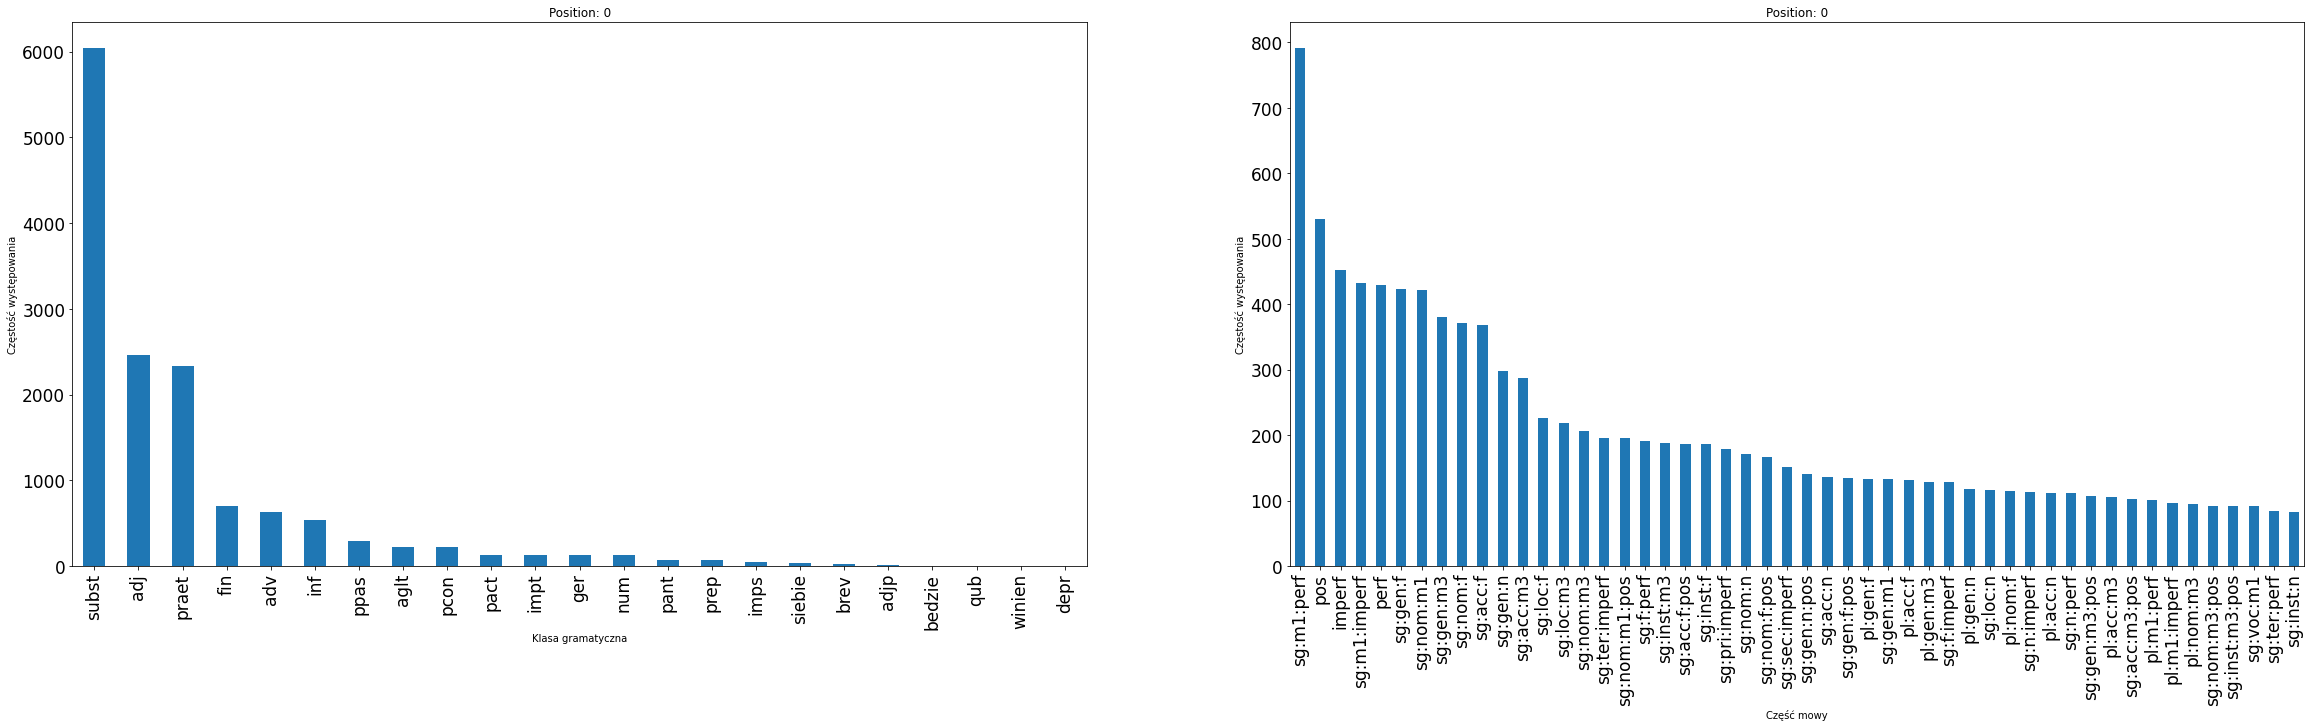

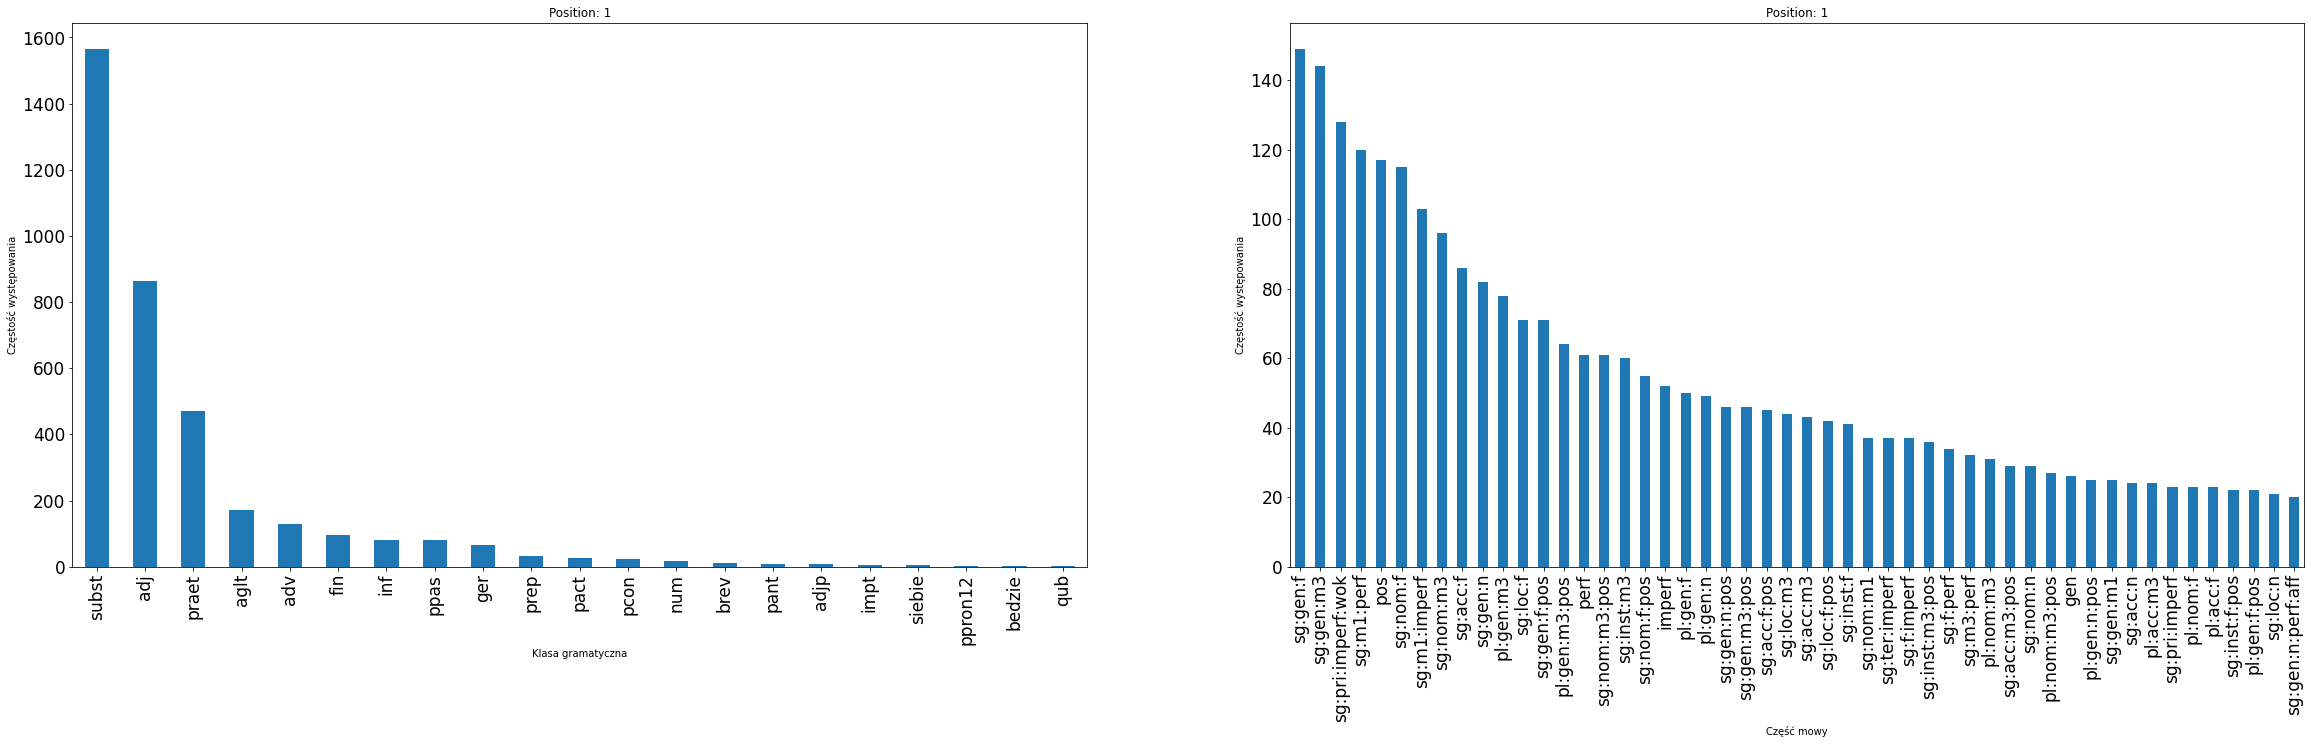

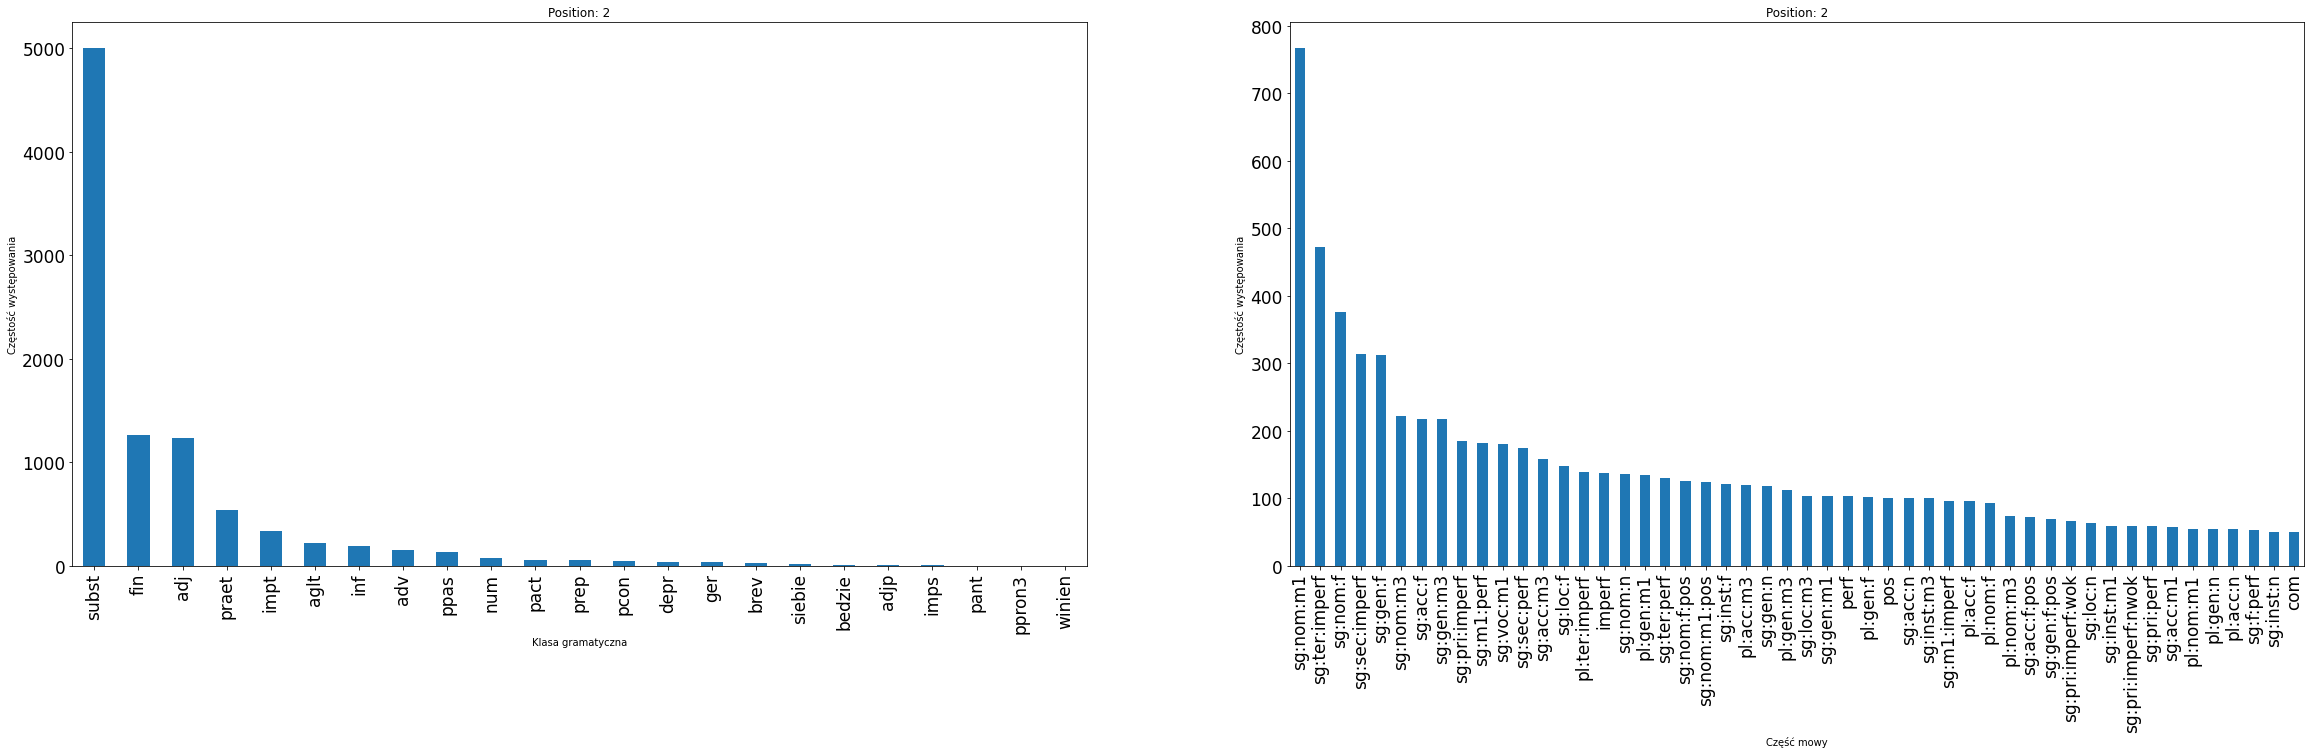

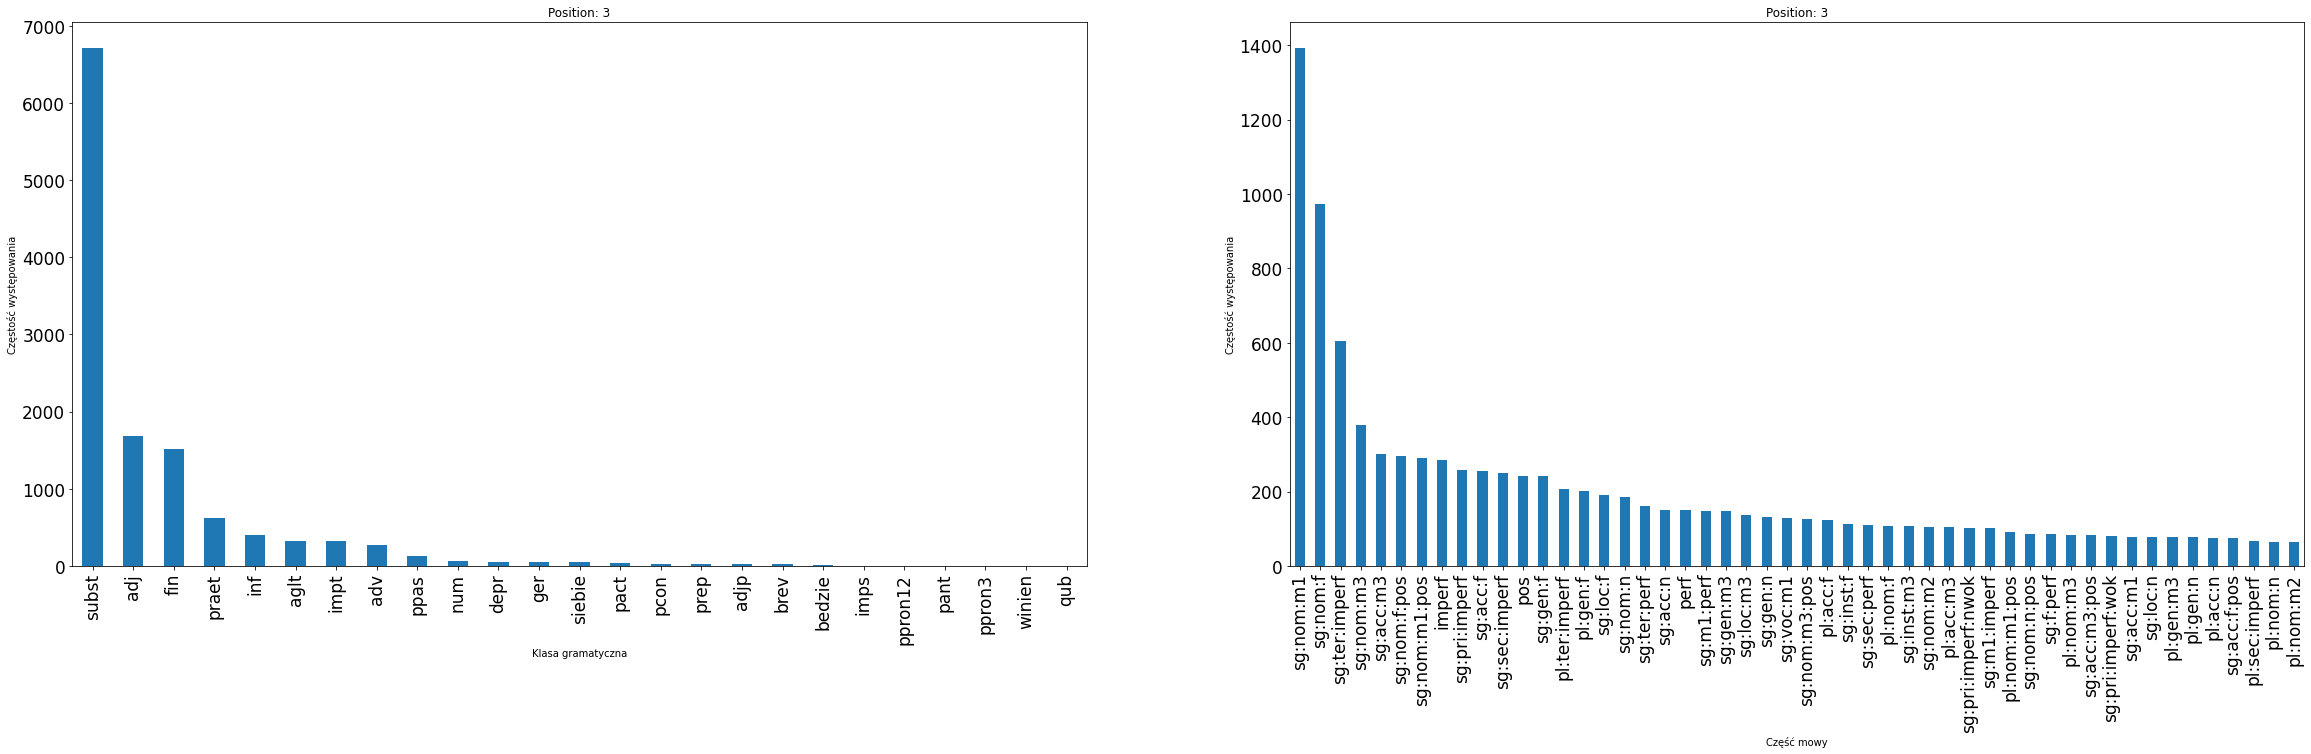

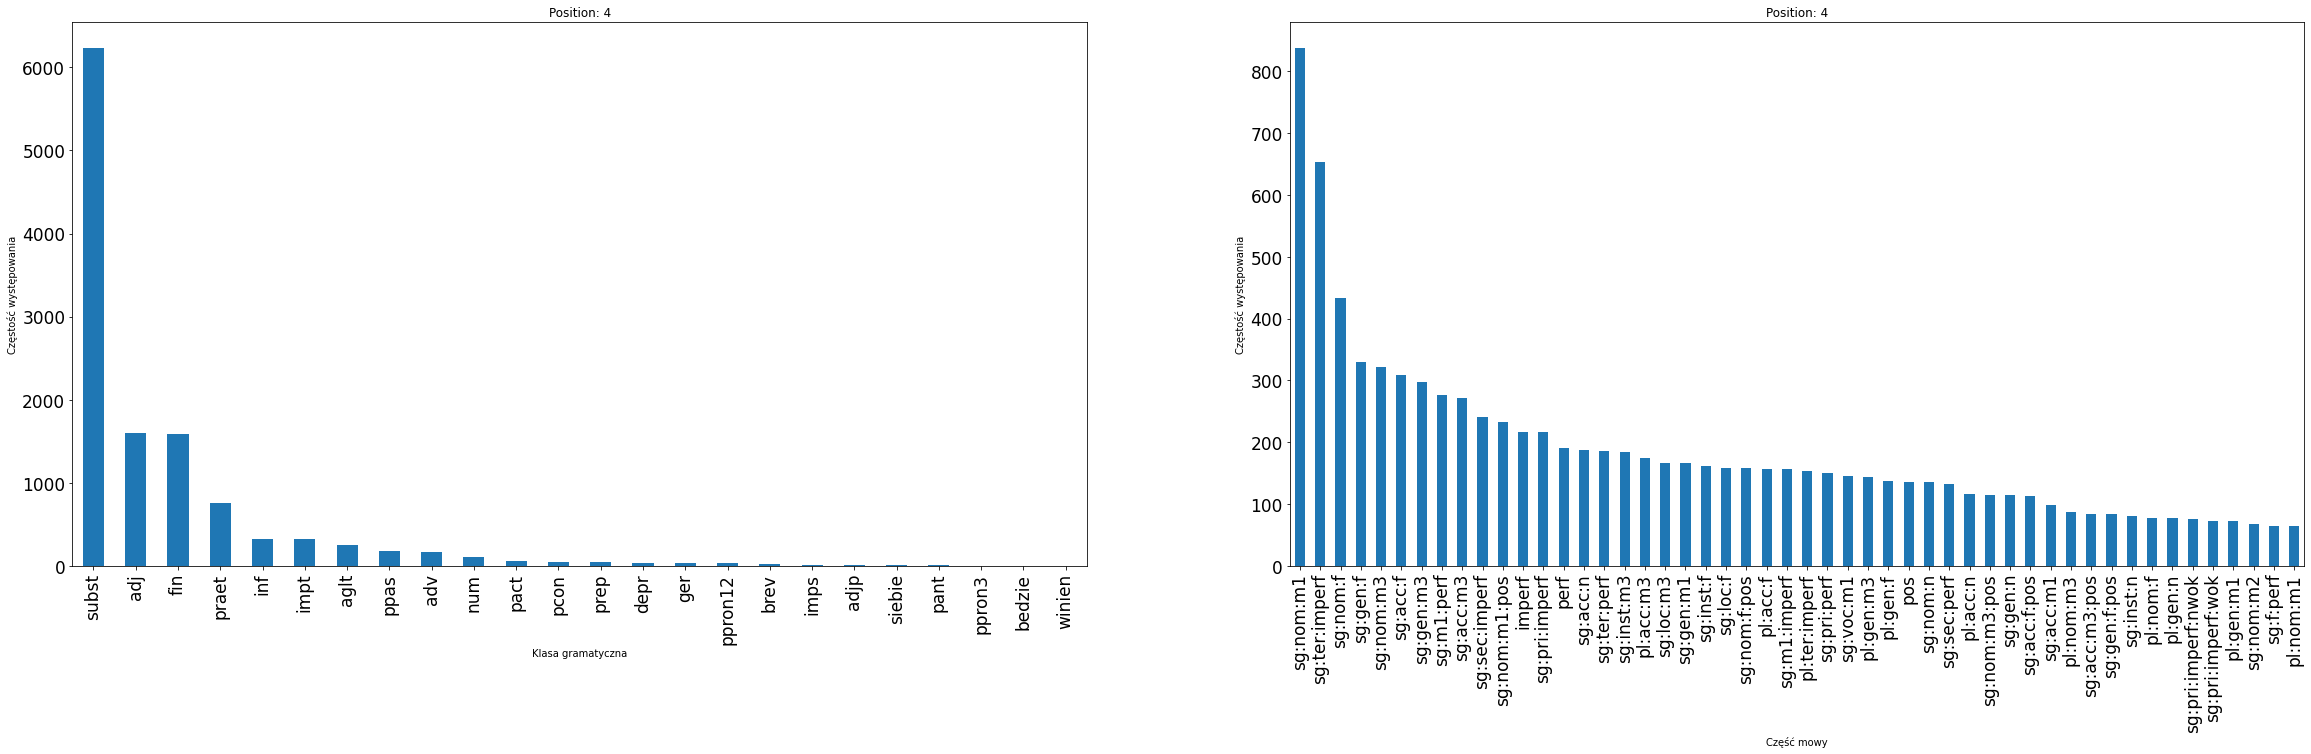

In [51]:
for i in flat_books:
  create_count_chart(flat_books.index(i))

#**3. Na podstawie korpusu zbudowanego   z 5 dowolnych książek ściągniętych ze strony Wolne Lektury wyznaczyć i zwizualizować częstość występowania rzeczowników sprowadzonych do form podstawowych.**

In [52]:
books_combined = ' '.join(flat_books)
all_tokens = tokenizer_lemma_token(books_combined)
table_df_all = pd.DataFrame(create_table(all_tokens))

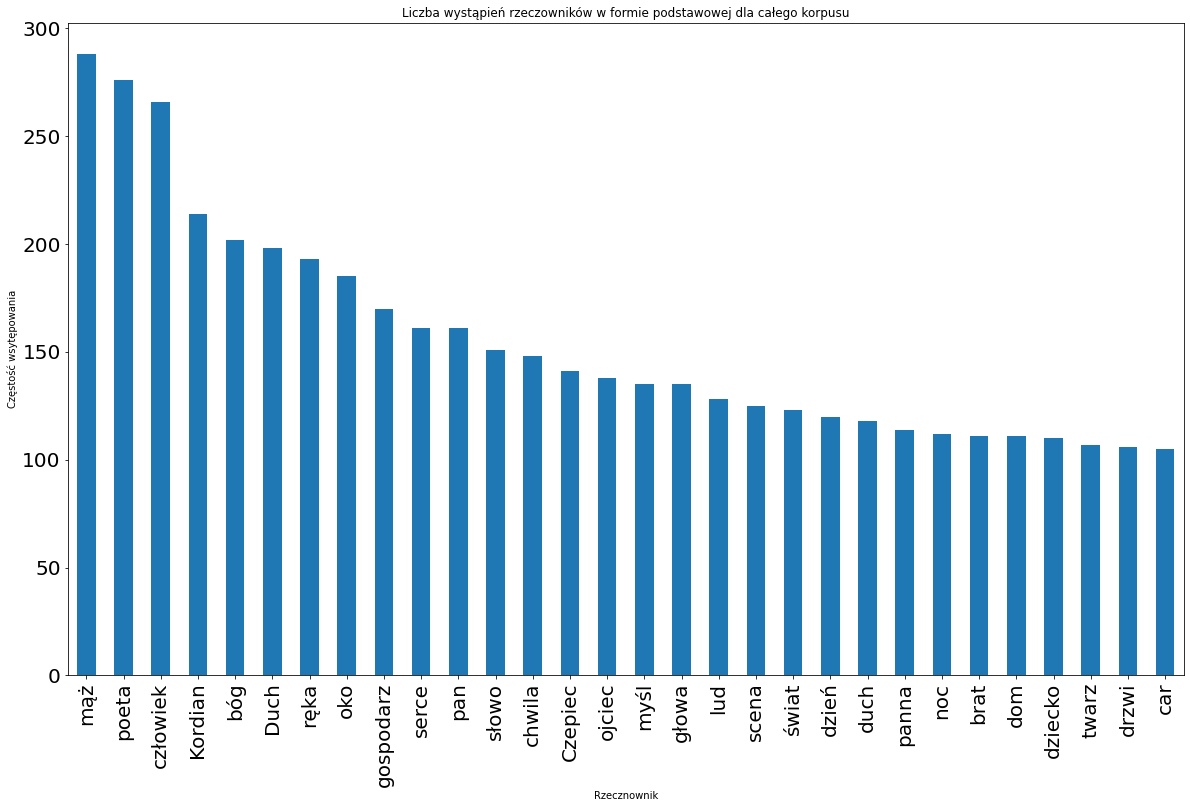

In [53]:
subst_filter = table_df_all.loc[table_df_all['tag'] == 'subst']
count_by_lemma = subst_filter.groupby('lemma').size().sort_values(ascending = False)[:30] #top30
count_by_lemma.plot(kind = "bar", figsize = (20,12), title ="Liczba wystąpień rzeczowników w formie podstawowej dla całego korpusu" , fontsize=  20, xlabel = "Rzecznownik", ylabel = "Częstość wsytępowania")

#**4.  Na podstawie częstości wyznaczonych powyżej  zbudować macierz tfidf, wyłącznie w oparciu o rzeczowniki w formie podstawowej i każdą pozycję zwizualizować w postaci chmury tagów (wordcloud).**

In [54]:
flat_books = [item for sublist in books for item in sublist]

In [55]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenizer)
tfidf = tfidf_vectorizer.fit_transform(flat_books)
tfidf_df = pd.DataFrame(tfidf.todense().tolist(), columns = tfidf_vectorizer.get_feature_names())
tfidf_df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Abel,Abraham,Adam,Afryka,Al,Aleksander,Aleksandra,Allan,Anda,Anna,Ante,Antoniusz,Art,BN,Balladyna,Baltazar,Baszkir,Beda,Bella,Berno,Białe,Biega,Blanc,Bob,Bogarodzica,Bolesław,Bonaparte,Boże,Branecki,Brutus,Błażek,CAF,Cała,Charles,Chopin,Choromańska,Chrystus,Ciężkie,Crusoe,Cyla,...,żandarm,żar,żarna,żart,żarłok,żałoba,żałość,żebrak,żeglarz,żegluga,żelastwo,żelaziwo,żelazo,żelezce,żmija,żniwa,żniwo,żona,żongler,żołnierz,żołądek,żuk,żuraw,żurawiec,żwir,życie,życzenie,życzliwość,żyd,żyto,żywiec,żywioł,żywność,żywot,żywość,żółw,żółć,żądanie,żądza,żądło
0,0.004815,0.003884,0.000000,0.000000,0.000000,0.000000,0.002294,0.000000,0.004815,0.000000,0.000000,0.000000,0.003884,0.000000,0.000000,0.003884,0.00000,0.000000,0.004815,0.000000,0.000000,0.000000,0.000000,0.207024,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.009629,0.000000,0.004815,0.000000,0.000000,0.009629,0.000000,...,0.000000,0.000000,0.000000,0.005425,0.000000,0.003224,0.000000,0.009629,0.000000,0.000000,0.003884,0.000000,0.002294,0.000000,0.000000,0.000000,0.0000,0.056961,0.004815,0.000000,0.009629,0.000000,0.000000,0.000000,0.000000,0.098648,0.031075,0.004815,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.004815,0.000000,0.000000,0.009629,0.002294,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009261,0.038869,0.000000,0.000000,0.000000,0.000000,0.000000,0.010949,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019434,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.021898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009261,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018521,0.000000,0.000000,0.000000,0.000000,0.015679,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009261,0.000000
2,0.000000,0.003263,0.006525,0.000000,0.000000,0.008088,0.001927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002278,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006525,0.000000,0.000000,0.000000,0.00000,0.004044,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016314,0.000000,0.000000,0.000000,...,0.000000,0.002708,0.000000,0.000000,0.004044,0.002708,0.000000,0.000000,0.000000,0.003263,0.000000,0.000000,0.009635,0.000000,0.009788,0.000000,0.0000,0.143537,0.000000,0.022839,0.000000,0.000000,0.000000,0.000000,0.004044,0.046249,0.006525,0.000000,0.013542,0.000000,0.003263,0.00000,0.004044,0.000000,0.000000,0.000000,0.000000,0.000000,0.001927,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.002617,0.000000,0.001247,0.000000,0.000000,0.000000,0.002617,0.000000,0.000000,0.001474,0.000000,0.000000,0.00000,0.005233,0.000000,0.002617,0.000000,0.002617,0.000000,0.000000,0.002111,0.000000,0.002617,0.002617,0.00785,0.000000,0.002617,0.002617,0.002617,0.000000,0.002617,0.000000,0.000000,0.002617,0.000000,0.005233,...,0.000000,0.008762,0.005233,0.001474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002111,0.002617,0.002494,0.002617,0.000000,0.002617,0.0157,0.023588,0.000000,0.000000,0.000000,0.000000,0.000000,0.005233,0.000000,0.007481,0.000000,0.000000,0.087623,0.002617,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001247,0.000000
4,0.000000,0.000000,0.008066,0.003332,0.000000,0.000000,0.001588,0.000000,0.000000,0.003332,0.000000,0.003332,0.002689,0.001877,0.003332,0.002689,0.01333,0.000000,0.000000,0.000000,0.003332,0.000000,0.003332,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016132,0.000000,0.000000,0.000000,...,0.006665,0.004464,0.000000,0.001877,0.000000,0.006695,0.003332,0.000000,0.003332,0.002689,0.000000,0.000000,0.006352,0.000000,0.005377,0.000000,0.0000,0.005632,0.000000,0.075281,0.000000,0.003332,0

In [56]:
def create_cloud_by_subst(position): #add title
  tfidf = tfidf_vectorizer.fit_transform(books[position])
  tfidf_df = pd.DataFrame(tfidf.todense().tolist(), columns = tfidf_vectorizer.get_feature_names())
  dict_pos = tfidf_df.iloc[0:1].to_dict('recorods')[0]

  wc = WordCloud(background_color="white",width=1500, height= 1000, max_words=100, normalize_plurals=False).generate_from_frequencies(dict_pos)

  plt.figure(figsize = (20,12), facecolor = None)
  plt.title("Position: " + str(position))

  plt.imshow(wc)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the opti

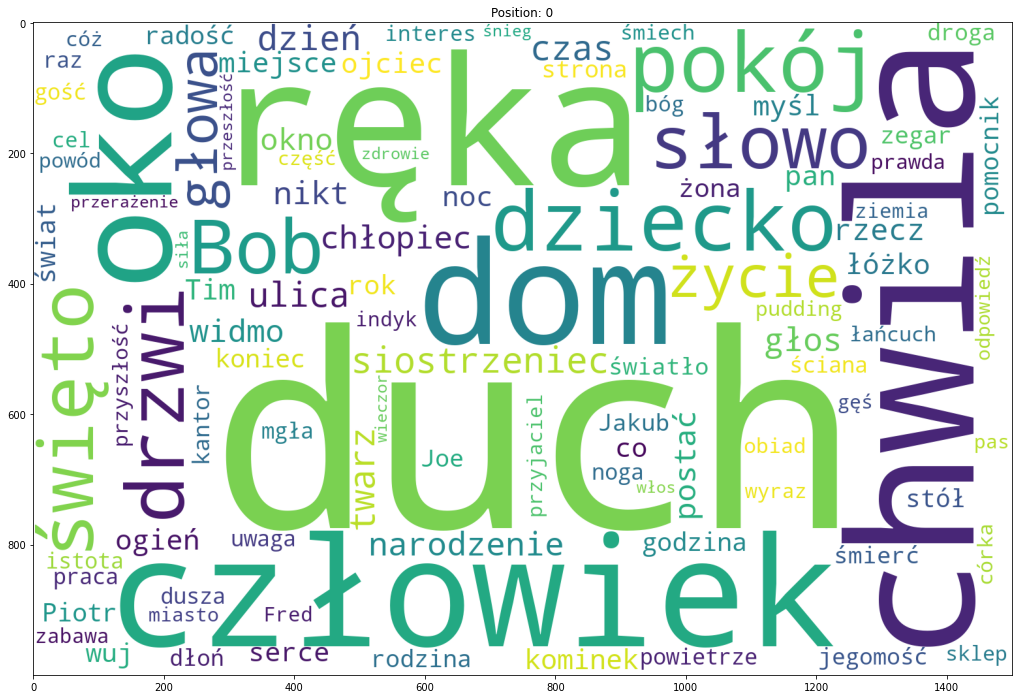

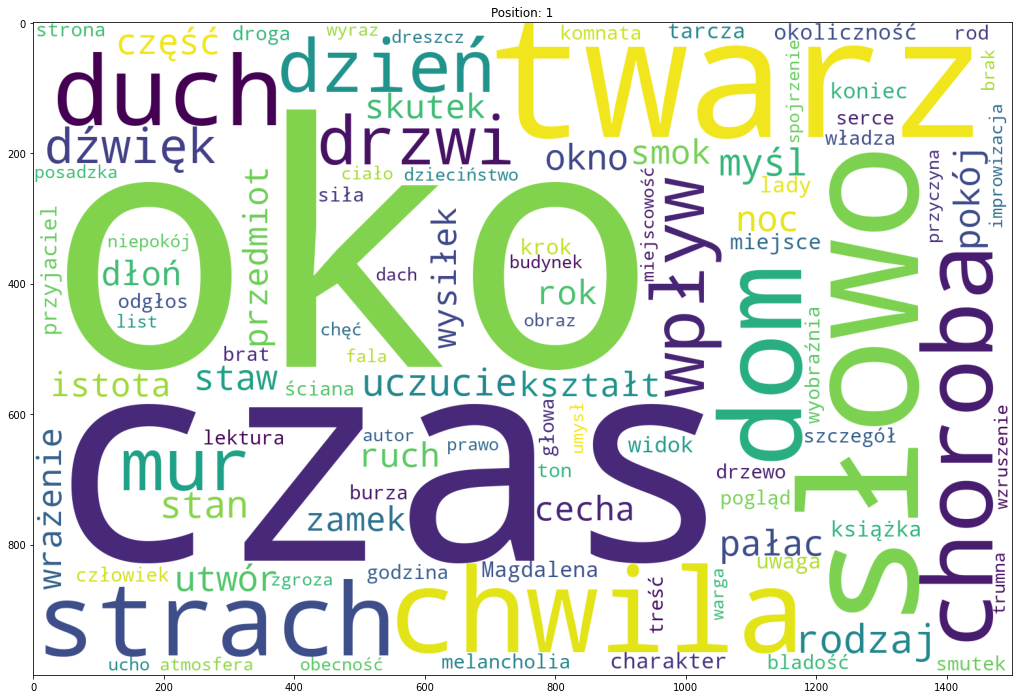

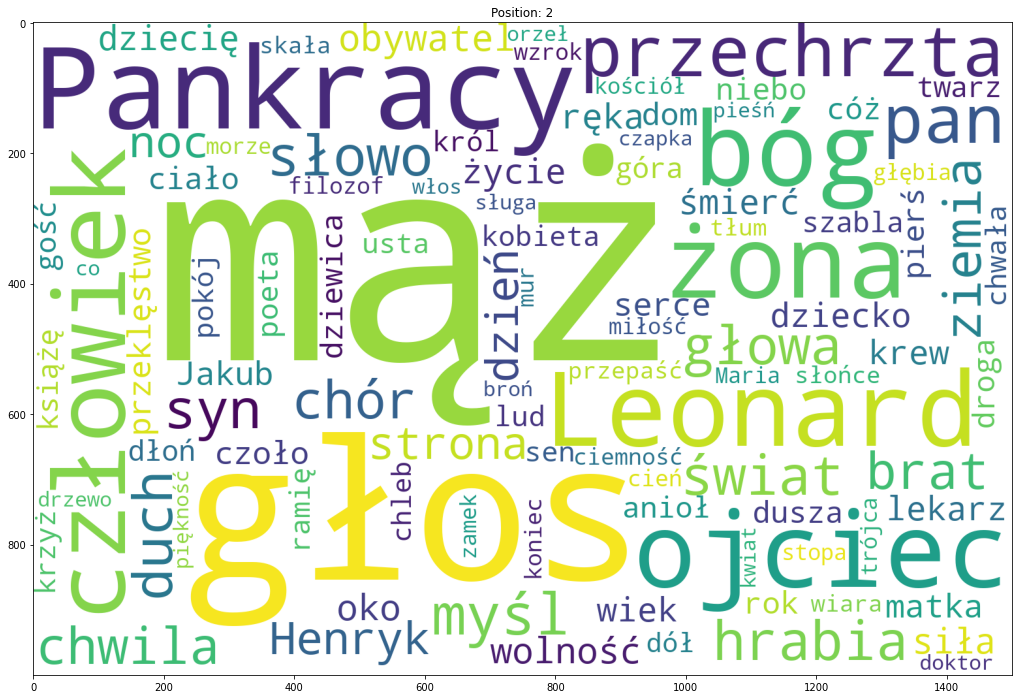

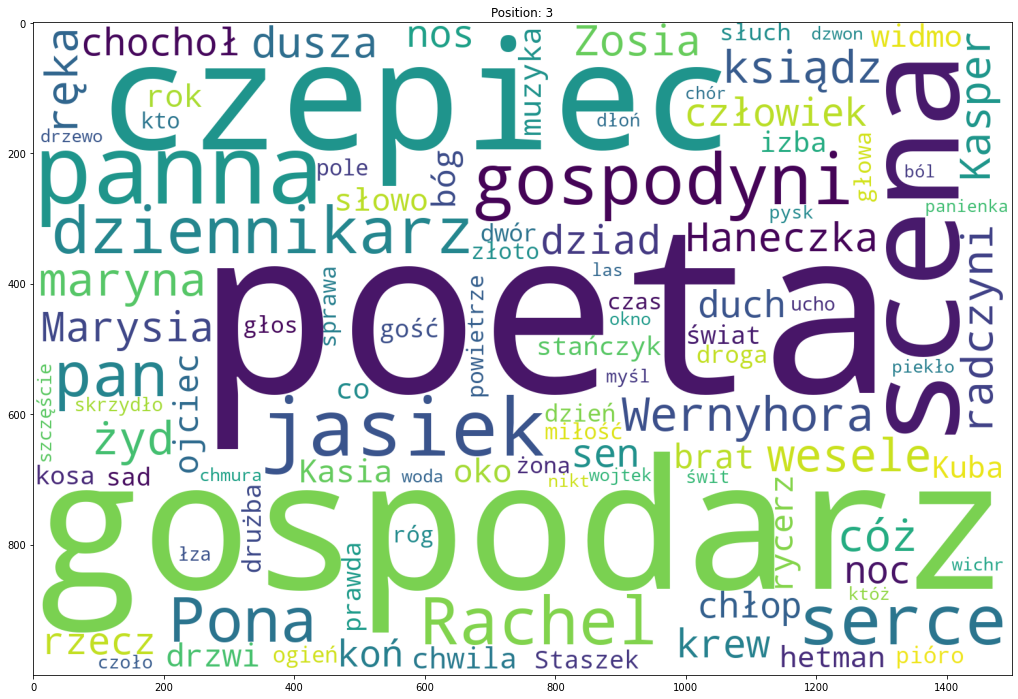

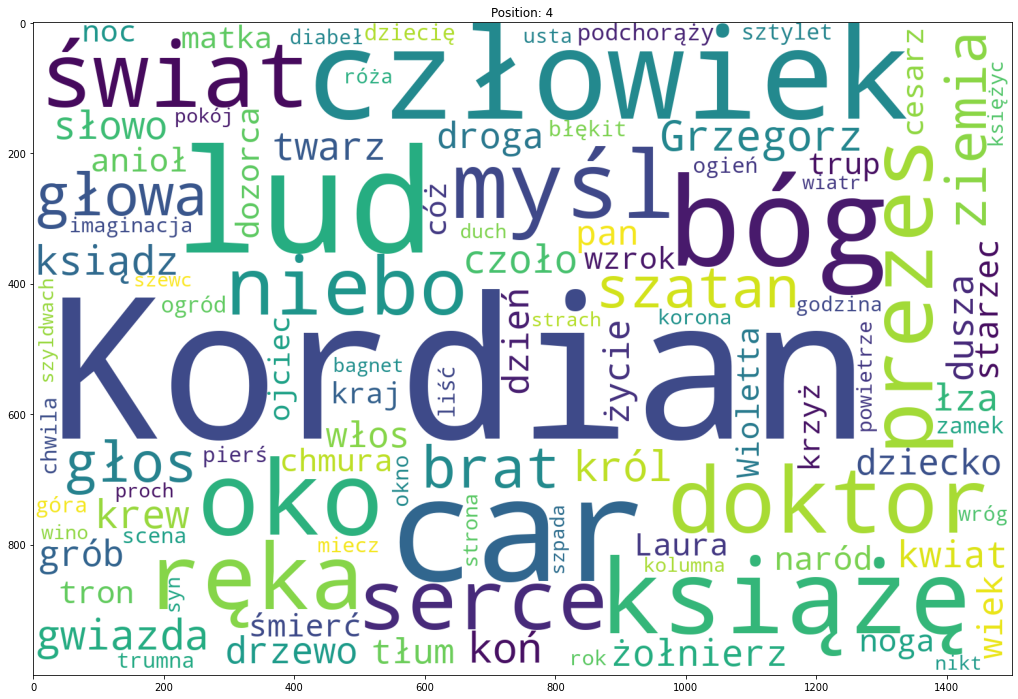

In [57]:
for i in flat_books:
  create_cloud_by_subst(flat_books.index(i))

#**5.  Podać kilka przykładów  niejednoznaczności znaczeniowej  występujacej w tekstach oraz przyjęty sposób ich rozwiązania**

In [183]:
morfeusz = morfeusz2.Morfeusz()
result = morfeusz.analyse(' '.join(flat_books))

analyseTable = pd.DataFrame(columns=["token_start", "token_end", "segment", "lemma", "interp", "common", "qualifiers"], data=[(row[0], row[1], *row[2]) for row in result] )\
  .groupby(['token_start','token_end','segment']).size().reset_index(name='count').sort_values(by=['count'], ascending=False)

analyseTable

,token_start,token_end,segment,count
20822,20780,20781,serio,25
40221,40139,40140,be,25
85515,85268,85269,serio,25
85519,85272,85273,serio,25
31411,31342,31343,serio,25
...,...,...,...,...
70383,70215,70216,jegomość,1
28809,28745,28746,—,1
70386,70218,70219,gniewa,1
70387,70219,70220,",",1


In [184]:
stop_words_url = urllib.request.urlopen("https://raw.githubusercontent.com/ekorn/Keywords/master/stopwords/polish-stopwords.txt")
stoplist = []
for line in stop_words_url:
  decoded_line = line.decode("utf-8").replace('\n', '').replace('\r', '')
  stoplist.append(decoded_line)


In [188]:
df = pd.DataFrame(columns=["token_start", "token_end", "segment", "lemma", "interp", "common", "qualifiers"], data=[(row[0], row[1], *row[2]) for row in result])
df = df.loc[df.segment.str.contains('^[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]*[A-Za-zżźćńółęąśŻŹĆĄŚĘŁÓŃ]$'), :]
df['segment'] = df['segment'].str.lower()
df = df[~df.segment.isin(stoplist)]
df = df.groupby('token_start').filter(lambda x: len(x) >1)

df[0:30]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,token_start,token_end,segment,lemma,interp,common,qualifiers
0,0,1,charles,Charles:Sm1~sa,subst:sg:nom:m1,"[imię, pseudonim]",[]
1,0,1,charles,Charles:Sm1~’a,subst:sg:nom:m1,[imię],[]
3,2,3,opowieść,opowieść,subst:sg:nom:f,[nazwa_pospolita],[]
4,2,3,opowieść,opowieść,subst:sg:acc:f,[nazwa_pospolita],[]
6,4,5,tłum,tłumić,impt:sg:sec:imperf,[],[]
7,4,5,tłum,tłum,subst:sg:nom.acc:m3,[nazwa_pospolita],[]
9,6,7,nieznany,znać:Vi,ppas:sg:acc:m3:imperf:neg,[],[]
10,6,7,nieznany,znać:Vi,ppas:sg:nom.voc:m1.m2.m3:imperf:neg,[],[]
11,6,7,nieznany,nieznany,adj:sg:acc:m3:pos,[],[]
12,6,7,nieznany,nieznany,adj:sg:nom.voc:m1.m2.m3:pos,[],[]


W badanych książkach występują przykłady niejednoznaczności znaczeniowej. 
Metoda klasy Morfeusz analyse() zwraca graf analizy morfoskładniowej dla podanych książek w postaci listy trójek uporządkowanych reprezentujących pojedyncze interpretacje poszczególnych segmentów (czyli krawędzie w grafie analizy). Każda trójka składa się z indeksów węzła początkowego i końcowego danej krawędzi oraz z interpretacji morfoskładniowej, stanowiącej etykietę krawędzie. 
formę tekstową,
* lemat (formę bazową/hasłową),
* znacznik morfoskładniowy,
* listę informacji o „pospolitości” rzeczownika (np. nazwa pospolita, marka,
nazwisko),
* listę kwalifikatorów stylistycznych (np. daw., pot., środ., wulg.) i dziedzionowych (np. bot., zool.).
Segmenty nieznane słownikowi otrzymują specjalny znacznik ign oraz lemat
równy formie tekstowej.


Jak widać we fragmencie powyższej tabeli powtarzające się słowa mają odmienne znaczniki morfoskładniowe, liste informacji na temat pospolitości rzeczownika oraz liste kwalifikatorów stylistycznych. 

**Przykłady niejednoznaczności**

* Słowo **stary** sklasyfikowano jako rzeczownik oraz jako przymiotnik.
* Słowo **nieznanny** sklasyfikowano jako przymiotnik oraz jako imiesłów przymiotnikowy przeszły bierny.
* Słowo **martwy** sklasyfikowano jako rzeczownik oraz jako przymiotnik.
* Słowo **tłum** sklasyfikowano jako rzeczownik oraz jako czasownik.
